In [24]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

Goal: Anomaly in number of web pages accessed in a day by a user. A bot copying curriculum? 

In [119]:
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [120]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

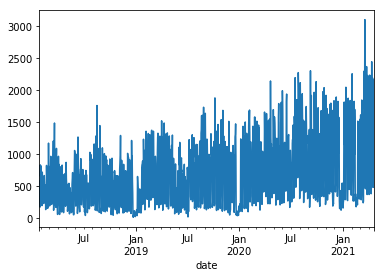

In [121]:
pages.plot()

In [122]:
end_train = '2020-06-30'
start_test = '2020-07-01'

train = pages[:end_train]
test = pages[start_test:]

In [123]:
train.tail()
test.head()

date
2020-07-01    814
2020-07-02    630
2020-07-03    280
2020-07-04    252
2020-07-05    290
Freq: D, Name: endpoint, dtype: int64

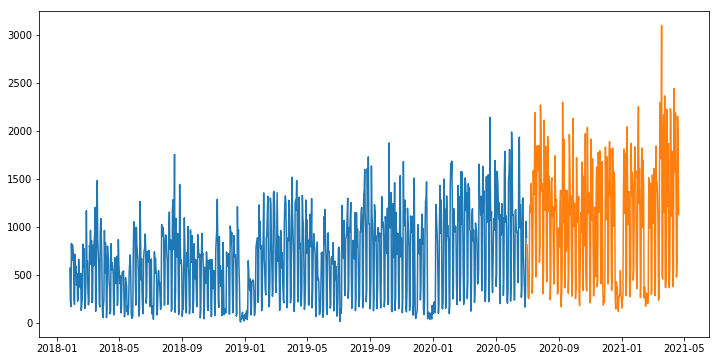

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(train)
plt.plot(test)
plt.show()

In [128]:
pages.isnull().sum()

0

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [132]:
# 7 day EMA
ema_short = train.ewm(span=7).mean()
ema_short.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [130]:
# 14 days EMA
ema_mid = train.ewm(span=14).mean()
ema_mid.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [131]:
# 30 days EMA
ema_long = train.ewm(span=30).mean()
ema_long.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

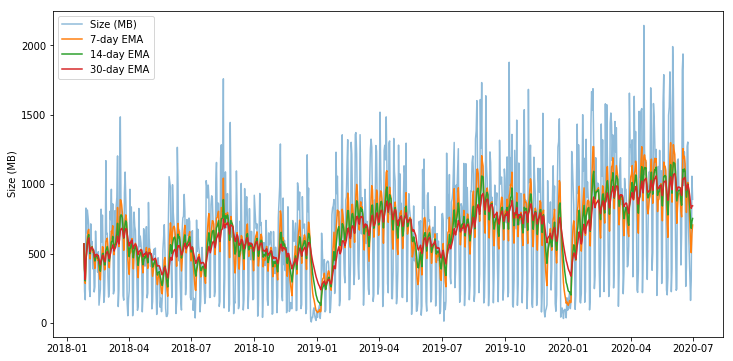

In [133]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, ema_short, label = '7-day EMA')
ax.plot(train.index, ema_mid, label = '14-day EMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [134]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

midband.head(2)

date
2018-01-26    572.0
2018-01-27    395.3
Freq: D, Name: endpoint, dtype: float64

In [135]:
# compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head(2)

date
2018-01-26           NaN
2018-01-27    241.830519
Freq: D, Name: endpoint, dtype: float64

In [136]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.head(3)

,endpoint,endpoint
date,,
2018-01-26,NaN,NaN
2018-01-27,878.961038,-88.361038
2018-01-28,742.895854,-112.616698


In [137]:
train = pd.concat([train, midband, bb], axis=1)
train.columns = ['size_gb', 'midband', 'ub', 'lb']

In [139]:
train.head()

,size_gb,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


Plot the bands

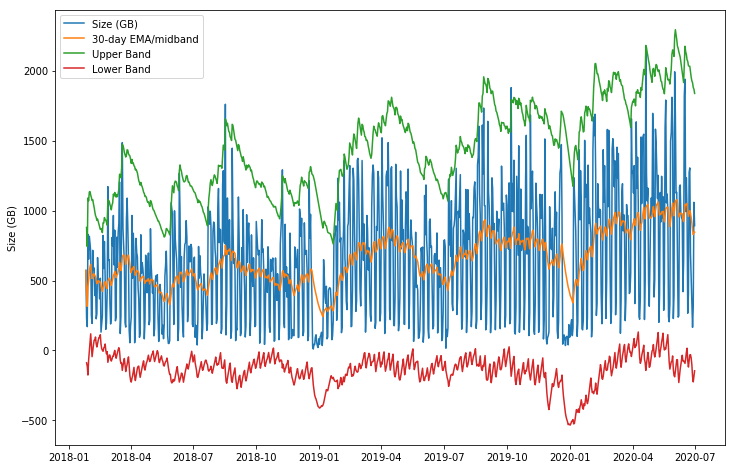

In [140]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.size_gb, label='Size (GB)')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [142]:
# get the last measure of gb
last_measure = train.iloc[-1].size_gb


# get the lower band value on the last date
last_lb = train.iloc[-1].lb

# get the upper band value on the last date
last_ub = train.iloc[-1].ub

# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.52


So, to compute for each point in time: 

In [145]:
train['pct_b'] = (train['size_gb'] - train['lb'])/(train['ub'] - train['lb'])

train.head()

,size_gb,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [146]:
train[train['pct_b']>1]

,size_gb,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [ ]:
def acquire(file_name, column_names):
    '''
    This function takes in two arguments, file_name: and, column_names: The names of each feature in the DF.
    Then the fucntion returns the file and reads it as a csv and formats and assigns each column to names.
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    This fucntion takes in a dataframe and the user column,
    creates a new dataframe called df where user_id == user,
    df.date is then formated to datetime format,
    then the index is set to date,
    and lastly pages is created through a daily resample of th endpoint feature,
    This fucntion will return pages a s a dataframe.
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    This fucntion will take in the dataframe pages, span , weight, and user.
    The midband, stdev, upperband, lowerband, bolengerband, are all created,
    my_df is assigned to the concat of the upperband and lowerband tables,
    my_df columns are assigned to their names of pages, midband, ub, lb,
    This fucntion will then create a pct_b category and a user_id feature that uses user.
    The function will return my_df.
    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''
    This function will take in my_df, and user dfs inorder to plot_the bolleger bands,
    first this function creates a figure with subplots, plots pages, midband, ub, lb, 
    then the legend is created to indetify each band,
    lastly the ylabels are set to be number of pages,
    This function will plot a viz representation of bollegerbands.
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    '''
    This function takes in df, user, span, and weight arguments inorder to identify anomalies,
    pages is created with the prep of df, user, 
    my_df is created by computing the percentage of b for pages, span, weight, user,
    then this fucntion will return my_df with pct_b values that are greater than 1. '''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]
